<a href="https://colab.research.google.com/github/meyer2097/Frame-Shift-Aware-Alignment/blob/main/Day3_GWAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today's topics
We will try to find out which phenotypic traits are associated with genetic markers in the BXD mouse population. This will allow us to make statements about the level of heritability of several traits and help us identify candidate genes responsible for specific traits.

There are several types of studies relevant in this context:

* Single gene association studies
* Genome wide association studies
* Phenome wide association studies

Today we'll perform a genome-wide association study. In particular, we will investigate which SNPs are associated with the coat color of mice.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy

## Load genotype data
To ensure that we all use the same input data, we provide the code you should load the genotype information with, just update the genotype tsv file's path to where you stored it on your system.

We split the table into metadata (`geno_meta`) and genotype data (`geno_bdh`) parts and index them with the `Locus` identifier.

In [3]:
genotype = pd.read_csv("genotype.txt", sep="\t", comment="@", index_col="Locus")
geno_meta = genotype.iloc[:, :3]
geno_bdh = genotype.iloc[:, 3:]

### Remove strains with a lot of missing genotype values
Before you convert the B/D/H/U labels to numeric, find the main culprits for the U (unknown) labels.
Only keep strains with less than 10 unknown loci and put them in `geno_bdh2`. Which strains did you have to remove?

In [4]:
geno_bdh2 = geno_bdh.loc[:, np.sum(geno_bdh == 'U', axis=0) < 10]

In [5]:
#Which strains did you have to remove?
print(geno_bdh.shape)
print(geno_bdh2.shape)

(3811, 93)
(3811, 90)


In [6]:
print("I had to remove three strais, these were ", set(geno_bdh.columns)-set(geno_bdh2.columns))

I had to remove three strais, these were  {'BXD102', 'BXD73b', 'BXD101'}


### Replace categorical genotype labels with numerical encoding

Unlike yesterday, we will use `{B: 0, H: 1, D: 2, U: 1}` encoding for the genotypes. Due to the previous step where we discarded strains with a lot of missing data, we have very few unknowns left, so it's acceptable to treat them as the intermediate heterozygous genotype instead of missing values. Call the numerical genotype dataframe `geno`.

In [7]:
geno = geno_bdh2.replace({'B': 0, 'H': 1, 'D': 2, 'U': 1}, inplace=False)


## Download coat color information from genenetworks.org

Most mouse phenotype data is available at genenetwork.org. This includes nearly all published phenotype measurements. You can access individual measurements from that repository using the search mask:
1. Go to http://gn2.genenetwork.org/
2. In "Select and Search" fill in:
    1. Species: Mouse
    2. Group: BXD RI Family
    3. Type: Phenotypes
    4. Dataset: BXD Published Phenotypes
3. Enter the trait of interest in the "Get any" field
4. Search

For getting data on the coat color of BXD mice use "coat color" as search term and select the Record __11280__ to get to the corresponding __Trait Data and Analysis__ page. There you can export the data as a CSV file.

## Load coat color data

On the coat color data description page you saw that the colors had already been numerically encoded, so you don't have to convert it yourself. But keep an eye out for missing values and remove them if they exist. For future reference, the color encoding was:

|color  | value  |
|-------|--------|
| black |  4     |
| grey  |  3     |
| brown |  2     |
| dilute|  1     |

In [9]:
#my version:  the downloaded file is different to the already provided, so...
path="BXD_11280.csv"
genotype = pd.read_csv(path, header=None, na_values='x', on_bad_lines='skip')
genotype

,0,1
0,Phenotype ID:,BXD_11280
1,Phenotype URL:,http://genenetwork.org/show_trait?trait_id=112...
2,Group:,BXD
3,Phenotype:,"Skin"","" pigmentation: Hair coat color"","" ordin..."
4,Authors:,"Lu L, Williams RW"
5,Title:,Gene loci that are related to the coat color
6,Journal:,NaN
7,Dataset Link:,http://gn1.genenetwork.org/webqtl/main.py?Form...
8,Export Date:,"September 28, 2022"
9,Export Time:,09:33 GMT


In [11]:
colors_df = pd.read_csv('coat_color.csv', header=None, na_values='x').dropna(axis=0)

colors_df.columns = ['strain', 'color']
colors_df.set_index('strain', inplace=True)
colors = colors_df['color']

# Association tests between variants and categorical phenotype
We will first start testing SNPs for their association with a *categorical* phenotype, coat color. It is known to be heritable, and therefore genetically determined to a large extent, so we'll try to find candidate genes that could be involved. The fist step is finding the right SNPs.

## Task: Perfom association test for a single SNP using $\chi^2$ test

The chi2 test is a suitable test to detect association between two categorical random variables. It compares their observed combination counts with the combination counts that would be expected if there was no association between the two variables. The p-value calculated by the chi2 test is a measure of how likely it is for the expected and actual combination counts to differ as much as they do by mere chance.

### Line up `geno` and `colors`

We have genotype information for a set of mouse strains, and color information for a largely overlapping, but different set. We can only use those strains in the analysis that are present in both datasets. So we should first find their intersection, and slice both datasets accordingly.

Before you do that though, notice that the strains C57BL/6J and DBA/2J (only present in the color dataset) are the original founders of the entire BXD strain family: C57BL/6J is B, and DBA/2J is D. Therefore you know their genotypes by definition: all B and all D on every locus. Insert them into `geno` accordingly.

Furthermore, since the coat color DataFrame has just one column, it really should be a Series instead, as storing 1-dimensional data in a 2-dimensional data structure for no good reason is potential source of bugs. It's only a DataFrame in the first place is because `pd.read_csv` produces DataFrames regardless of the input file's shape. Slice the color DataFrame's only column and store it in the `colors` Series.

In [12]:
geno["C57BL/6J"] = 0 # "D"
geno["DBA/2J"] = 2 # "B"
pd.Series(colors)
overlap = colors.index.intersection(geno.columns)
geno = geno.loc[:, overlap]
colors = colors.loc[overlap]
colors

C57BL/6J    4.0
DBA/2J      1.0
BXD1        1.0
BXD2        4.0
BXD5        3.0
           ... 
BXD94       3.0
BXD95       1.0
BXD98       1.0
BXD99       1.0
BXD100      4.0
Name: color, Length: 89, dtype: float64

### Extract the genotype information for a single SNP
Store it in the variable `one_geno`.

In [13]:
one_geno = geno.iloc[0,:]
one_geno

C57BL/6J    0
DBA/2J      2
BXD1        0
BXD2        0
BXD5        2
           ..
BXD94       2
BXD95       2
BXD98       0
BXD99       0
BXD100      0
Name: rs6269442, Length: 89, dtype: int64

### Plot relationship between genotye and phenotype
You can use a scatter plot, but equal values will occlude each other, so you should add some jitter (small random noise). You can achieve this by generating random values in the same shape as your DataFrame, and adding it.

You can also try a heatmap, but make sure your color range starts from zero.

In [14]:
jit1 = 0.1*np.random.random_sample(one_geno.shape) - 0.1
jit2 = 0.3*np.random.random_sample(colors.shape) - 0.1
new_fur = colors + jit2
new_geno = one_geno + jit1



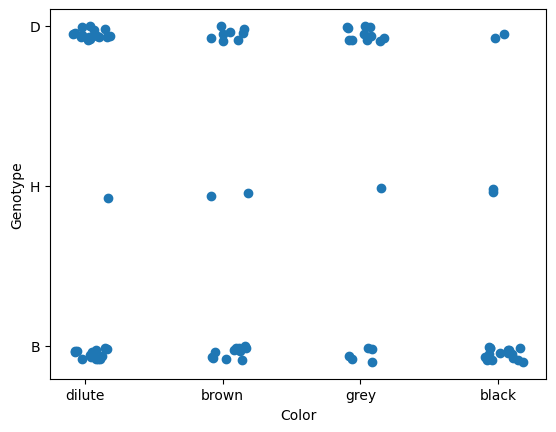

In [15]:

plt.scatter(new_fur, new_geno)
plt.xlabel("Color")
plt.ylabel("Genotype")
plt.xticks(np.arange(4)+1, ['dilute', 'brown', 'grey', 'black']);
plt.yticks([0,1,2], ['B',"H", 'D']);
plt.show()



We can not see much here and can not draw inforamtion out of it. MAybe the D has less points at black, indicating it has less often a black furr. But the representation is not optimal

<Axes: >

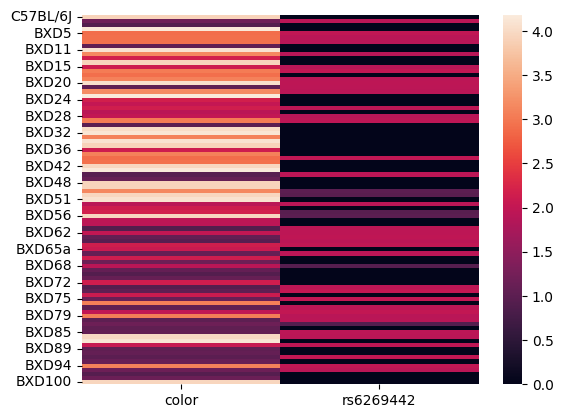

In [16]:
heatplot = pd.concat([new_fur, new_geno], axis=1)
sns.heatmap(heatplot, vmin = 0)

### Create a contingency table for a D-dominant inheritance model of black coat color for your SNP

What does D-dominant mean here, how should you treat the heterozygous genotype? Think about the individual cells of the contingency matrix: it has a 2x2 shape, but you have 3 kinds of genotypes and 4 kinds of colors. How should you collapse your data to binary labels?

Tip: Pandas' `crosstab` functionality may be helpful for you.

D-dominant means we only look at D. So  we have D and not D, black or not black. We only look at D dominant strains and the color black,

In [17]:
crosstab = pd.crosstab((one_geno == 0), (colors < 4)) #colors 4 black, geno 0 D , 2 B, 1 H. So
crosstab

color,False,True
rs6269442,,
False,4,38
True,16,31


### Perform a $\chi^2$ square test for independence on the contingency table

Find a suitable method in `scipy.stats` and read its documentation to understand what the returned values are. How can you access the test's p-value?

Describe the scipy.stats.chi2_contingency function!

In [18]:
statistic, pvalue, dof, expected_freq = scipy.stats.chi2_contingency(crosstab)
pvalue

0.01200075172875716

## Sidenote: penetrance models instead of dominance models

We have just used a D-dominant model with a 2x2 contingency table and performed a $\chi^2$ test with the smallest possible degrees of freedom (1). We assumed that a heterozygous genotype behaves the same way as a homozygous D genotype does.

It is sometimes useful to consider the full complexity of a genotype considering all three possible genotypes instead of just two. We could have used a $\chi^2$ test  with a 3x2 contingency table, and thus 2 degrees of freedom, but a more popular choice for such models is the Cochran–Armitage trend test, which usually has larger statistical power. In this case, the "penetrance" of the D allele is assumed to be additive: two alleles makes it twice as likely to exhibit the trait than one.

You can read more about basic statistical approaches in genetic association tests in the following paper:

__G. Clarke et al.       
[Basic statistical analysis in genetic case-control studies](http://www.nature.com/nprot/journal/v6/n2/full/nprot.2010.182.html)__,      
Nat. Protocols, 2011/02,     
http://dx.doi.org/10.1038/nprot.2010.182
<br>
<br>

For this task, you don't have to write code, just answer this one question: Would it make practical sense to use such a model with our data? Why?

The proportion of genotypes that actually show expected phenotypes is called penetrance. For example, say everyone in population W carries the same allele combinations for a certain trait, yet only 85% of the population actually shows the phenotype expected from those allele combinations. In this case, the penetrance is 85% and thus incomplete.
In contrast, the fur colour of mice is inherited dominantly and we thus expect a complete penetrance of the dominant phenotype in heterozygous mice. Thus, using a higher degree of freedom and assuming additive penetrance is not practical in our case. We can simplify the model to account for the complete penetrance of fur colour.

## Refactor the previous analysis steps into a function and apply to all SNPs

Try to do it without writing any `for` loops. Use the built-in iterating functionality that pandas provides with the `apply` method.

If you are ahead of schedule, you could try to come up with a faster approach. Doing 3811 cross-tabulations from scratch might be a bit wasteful, since the coat color labels are constant in every iteration. It is possible to calculate all 3811 contingency table values with a few simple operations, and therefore run all chi2 tests in a matter of seconds instead of a minute.

But speed doesn't really matter for us now. Whichever way you do it, answer the following question:

How many SNPs are associated with coat color at a p<0.05 significance threshold?

In [19]:
def chi2_all(one_geno, colors):
    p = scipy.stats.chi2_contingency(pd.crosstab((one_geno == 0), (colors < 4)))[1]
    return p

ps = geno.apply(chi2_all, colors=colors, axis=1)
counts = (ps < 0.05).sum()
print(str(counts) + " SNPs are associated with coat color at a p<0.05 significance threshold")

253 SNPs are associated with coat color at a p<0.05 significance threshold


### Add the p-values to the SNP metadata (`geno_meta`) DataFrame

Insert them as a new column called `p_raw`.

In [20]:
geno_meta["p_raw"] = ps

### Create a Manhattan Plot of  $-\log_{10}(\text{P-value})$ vs chromosome position
A Manhattan plot, named after its resemblance to the skyline of Manhattan, is commonly used to plot the p-values of SNP association tests against their genomic position.

Technically, it's a scatter plot of genome position vs the negative base-10 logarithm of the p-value (~how many zeroes does the p-value begin with). Try to recreate something like the plot below. It doesn't have to be an exact match, but at least the chromosomes should be distinguishable.

Think about how to convert chromosome number + Mb position within the chromosome into a single absolute position on the x-axis.

Hints: you can iterate over a pandas `groupby` object, so you can plot p-values chromosome-by-chromosome. This would mean 20 successive plotting calls in a `for` loop, which is perfectly fine.

Watch out: the `Chr` column may look numeric, but it is in fact a string column due to the `X` chromosome. If you don't want them to be sorted as strings (1, 10, 11, ..., 19, 2, 3, 4) you can prevent it by passing `sort=False` to the `geno_meta.groupby(...)` method as a keyword argument. <<< CHANGED TEXT HERE

![image.png](attachment:06d097a5-4ace-4dc3-9446-9c4e74a663e8.png)

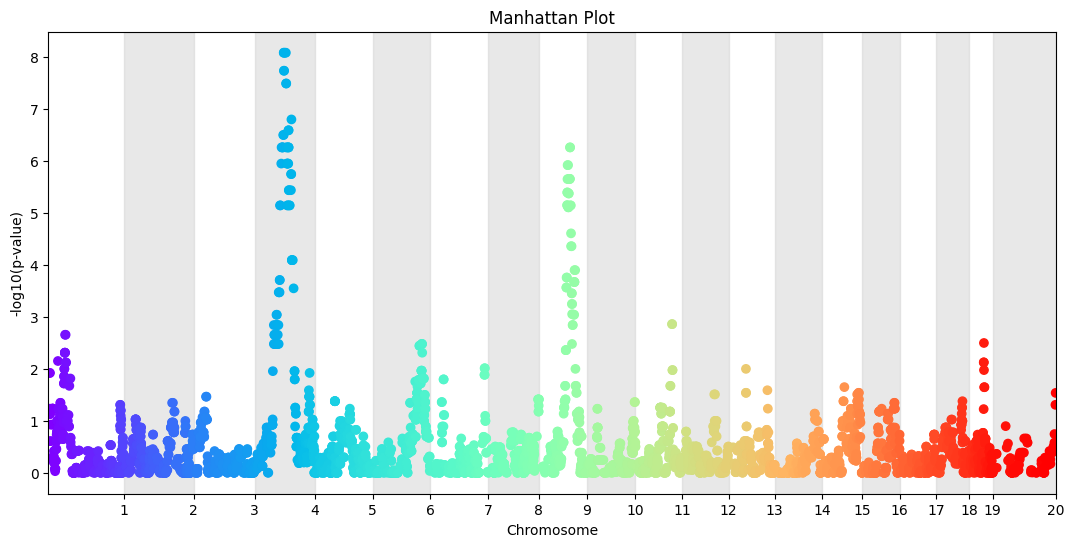

In [21]:
from matplotlib.pyplot import cm

chr_mapping = {str(i): i for i in range(1, 20)}
chr_mapping['X'] = 20
geno_meta['CHR_numeric'] = geno_meta['Chr'].map(chr_mapping)

geno_meta_sorted = geno_meta.sort_values(by=['CHR_numeric', 'Mb'])

absolute_positions = []
cumulative_length = 0
for chr_group, group_df in geno_meta_sorted.groupby('CHR_numeric', sort=False):
    absolute_positions.extend(group_df['Mb'] + cumulative_length)
    cumulative_length += group_df['Mb'].max()

geno_meta_sorted['Absolute_Position'] = absolute_positions
ps = geno_meta.shape[0]
plt.figure(figsize=(13, 6))
ax = plt.axes()
ax.set_facecolor("white")

chromosome_boundaries = geno_meta_sorted.groupby('CHR_numeric')['Absolute_Position'].max()
for i in range(1, len(chromosome_boundaries), 2):
    plt.axvspan(chromosome_boundaries[i], chromosome_boundaries[i+1], color="lightgrey", alpha=0.5)

color = cm.rainbow(np.linspace(0, 1, ps))
plt.scatter(geno_meta_sorted['Absolute_Position'], -np.log10(geno_meta_sorted['p_raw']), c=color)
plt.xlim([0, geno_meta_sorted["Absolute_Position"].iloc[-1]])

plt.xlabel('Chromosome')
plt.ylabel('-log10(p-value)')
plt.title('Manhattan Plot')
plt.xticks(chromosome_boundaries, np.array(list(set(geno_meta['CHR_numeric']))))

plt.show()

## Task: Correction for Multiple Hypothesis Testing

### Preliminary task: p-value histograms

Plot a histogram of all the p-values that you got from the $\chi^2$ tests. Generate the same amount of random uniformly distributed values between [0,1], and put them on the same histogram for a baseline comparison. (Remember, a chi2 test, or any well-calibrated statistical test would always produce a uniform distribution if there was no association between two random variables.)

Will any of our p-values survive multiple testing correction in your opinion? If so, guess how many! If necessary, increase the number of bins to capture the differences between the two histograms near p=0.

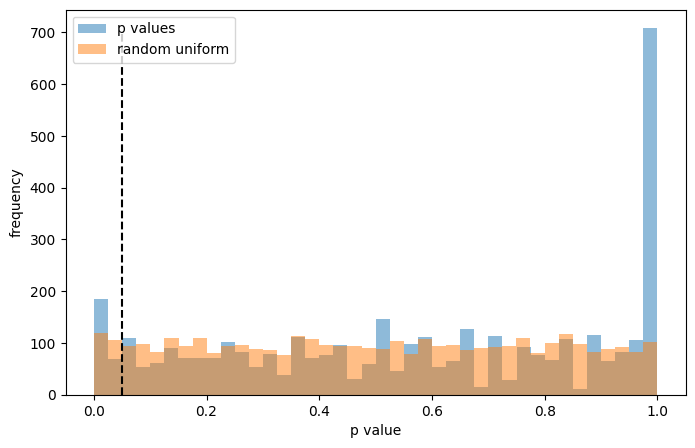

In [22]:
uniform_rand = np.random.uniform(size=len(geno_meta))
fig = plt.figure(figsize=(8,5))
plt.hist(geno_meta['p_raw'], alpha=.5, label='p values', bins=40)
plt.hist(uniform_rand, alpha=.5, label='random uniform', bins=40)
plt.xlabel('p value')
plt.ylabel('frequency')
plt.vlines(0.05, 0, 700, color='black', linestyle='--')
plt.legend();

The black dotted line represents our significant threshold 0.05. Since we know that the BH correction equally distributes the values we can estimate the number of remaining SNPs by looking at the blue area in the plot between 0 and 0.05 that is not overlapped by the orange uniform distribution. With this we estimate that approximately 100 SNPs will remain significant after correction.

### Use the Benjamini-Hochberg correction method to take care of the multiple hypothesis testing problem

Insert the B-H corrected p-values into the locus information DataFrame `geno_meta` as a new column named `p_bh`.

After the Benjamini-Hochberg correction, how many SNPs stayed significantly associated with coat color at the p<0.05 level? Compare this number with your earlier guess based on the raw p-value histogram. (And perhaps ponder: have we *really* tested 3811 different association hypotheses?)

In [23]:
from statsmodels.stats.multitest import multipletests
rejected, corrected_p_values, _, _ = multipletests(geno_meta['p_raw'], method='fdr_bh')
geno_meta['p_bh']= corrected_p_values
results_df = pd.DataFrame({
    'Original p-values': geno_meta['p_raw'],
    'Corrected p-values (BH)': corrected_p_values,
    'Rejected': rejected
})
n_rejected = results_df['Rejected'].sum()
print(f'After BH correction, {n_rejected} SNPs are associated with black coat color')

After BH correction, 89 SNPs are associated with black coat color


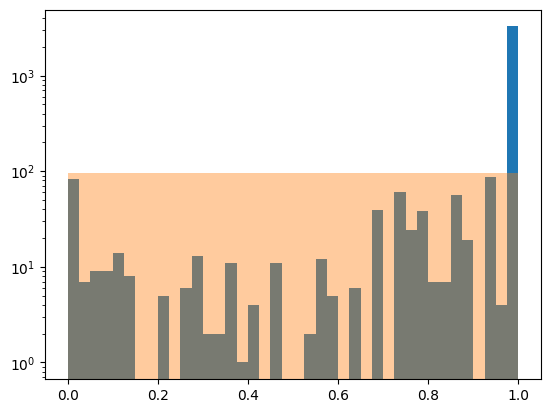

In [24]:
plt.hist(geno_meta['p_bh'], bins=40)
plt.hist(np.linspace(0, 1, len(geno_meta)), bins=40, alpha=0.4)
plt.yscale('log')

### Plot a histogram of the corrected p-values

Compare it with the original histogram of raw p-values. Does it match your expectations?

If you want, you can also try to recreate the Manhattan plot with the corrected p-values this time.

The histogram of the corrected p-values does match the expectation: the very evenly distributed raw p-values shifted after the correction to a much mor uneven distribution: there are very few significant corrected p-values and a lot of corrected p-values that have a very high value.

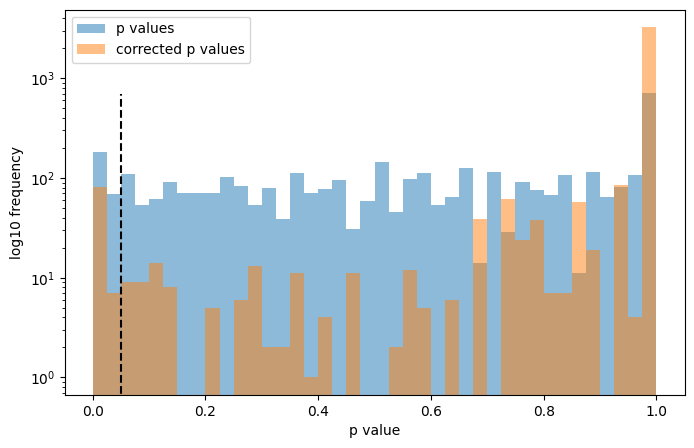

In [25]:
fig = plt.figure(figsize=(8,5))
plt.hist(geno_meta['p_raw'], alpha=.5, label='p values', bins=40)
plt.hist(results_df['Corrected p-values (BH)'], alpha=.5, label='corrected p values', bins=40)
plt.vlines(0.05, 0, 700, color='black', linestyle='--')
plt.xlabel('p value')
plt.ylabel('log10 frequency')
plt.yscale('log')
plt.legend();

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()

In [ ]:
#import matplotlib as mpl
#fm = mpl.font_manager
#fm.get_cachedir()

from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'

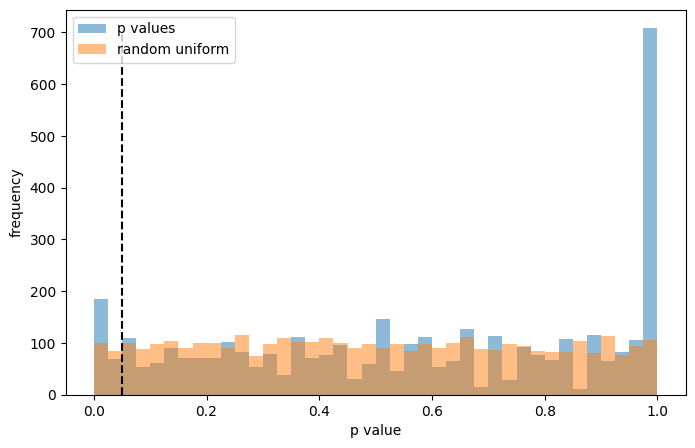

In [27]:
uniform_rand = np.random.uniform(size=len(geno_meta))
fig = plt.figure(figsize=(8,5))
plt.hist(geno_meta['p_raw'], alpha=.5, label='p values', bins=40)
plt.hist(uniform_rand, alpha=.5, label='random uniform', bins=40)
plt.xlabel('p value')
plt.ylabel('frequency')
plt.vlines(0.05, 0, 700, color='black', linestyle='--')
plt.legend();

In [28]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

## Task: Identify candidate genes from the significantly associated loci

What we identified so far are trait associated SNPs. This doesn't mean there is directly a causal relationship between the markers identified in the association study and the phenotype. It is, however, a pointer towards the region of the genome that may be relevant for the variability in the measured trait. The genes encompassed in this region then need to be analysed further to identify viable mechanistic candidates.

A good starting point for this fine grained analysis would be to look up the genes directly linked to the interesting SNPs in a mouse genome database (e.g, http://www.informatics.jax.org/snp/ ).

Most likely the high ranking SNPs will not map directly to the causal gene, but will rather be markers for another variant in a gene in strong __linkage disequilibrium__ with these SNPs. We thus need to extend the search and look at other genes in the vicinity of the high ranking SNPs (i.e. the entire region where the best SNPs are found). Since they are typically inherited together, it's hard to say which  of them are the truly causal variants.

Your task is to find candidate *genes* (instead of SNPs) using the website above. Reminder: the original BXD parent strains were called C57BL/6J and DBA/2J. Note that you can query entire regions, and in the query results page you can further filter the listed SNPs based on their properties (e.g. coding variant).

Another resource you can use is the [UCSC Genome Browser](http://genome.ucsc.edu/) for visual explorations, or the [UCSC Table Browser](http://genome.ucsc.edu/cgi-bin/hgTables?hgsid=511555905_oFRLEcH1IWO1FdKyzynrsBCRMk7w) to obtain genes in a genomic region. The identifiers of proteins in the [Uniprot](http://www.uniprot.org/) database are listed in the resulting table. Uniprot then can provide useful annotations of the proteins found in the search frame.

For the truly dedicated, or those with extra time on their hands, programmatic access is possible with the following services via a REST interface:

[UCSC](http://genomewiki.ucsc.edu/index.php/Programmatic_access_to_the_Genome_Browser)     
[Biomart](http://www.ensembl.org/info/data/biomart/biomart_restful.html)    
[Uniprot](http://www.uniprot.org/help/programmatic_access)      

But it's really just an extra task, and it's fine to use the websites via browser.

As candidate genes, we report Tyrp1 found on chromosome 4, which plays a role in melanin biosynthesis, may regulate or influence the type of melanin synthesized and is partially capable of hydroxylating tyrosine and producing melanin[UniProt].Further, there are three proteins that could influence the development of the skin itself. Bnc2, a zinc finger protein, is a probable transcription factor specific for skin keratinocytes. This gene was also reported as an influence on the eye color of mice, together with the eye growth influecing Myo5a, which we did find on the ROI on chromosome 9. Frem1 is an extracellular matrix protein that plays a role in epidermal differentiation and is required for epidermal adhesion during embryonic development. Lastly, MEGF9 is the abbreviation of 'Multiple epidermal growth factor-like', which could also contribute to the skin variance

In [29]:
#access the names of the SNPs associated with fur colour
name_array = results_df[results_df['Rejected']].index.values
ROI = geno_meta[geno_meta["p_bh"] < 0.05]
ROI.sort_values('p_bh')

,Chr,cM,Mb,p_raw,CHR_numeric,p_bh
Locus,,,,,,
rs3708061,4,41.281,80.950126,8.233611e-09,4,0.000008
rs13477796,4,41.281,78.698063,8.233611e-09,4,0.000008
CEL-4_74121566,4,40.708,75.493222,8.233611e-09,4,0.000008
CEL-4_74066970,4,40.708,75.438626,8.233611e-09,4,0.000008
rs3658567,4,40.995,76.484833,1.829728e-08,4,0.000012
...,...,...,...,...,...,...
rs13480319,9,52.406,86.456294,8.868787e-04,9,0.038987
rs3693091,9,53.570,90.299275,9.104820e-04,9,0.038987
gnf09.088.487,9,53.570,91.799939,9.104820e-04,9,0.038987


YOUR ANSWER HERE

### Check if the genes you found match the literature about genetics of mouse coat color

Hint / spoiler: ([PMC2736153](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2736153)).

As candidate genes, we report Tyrp1 found on chromosome 4, which plays a role in melanin biosynthesis, may regulate or influence the type of melanin synthesized and is partially capable of hydroxylating tyrosine and producing melanin[UniProt]. Further, Bnc2, a zinc finger protein, is a probable transcription factor specific for skin keratinocytes.

This gene was also reported as an influence on the eye color of mice, together with the eye growth influecing Myo5a, which we did find on the ROI on chromosome 9.

TCF12 WDR31 or 21

Not also in mice but also in other mammals, pubmed database
Around 75-80 significant regions and proteins